In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.special as sp
import pycodamath as coda
from pycodamath import extra
import scipy.optimize as optimization

#### 1. Data Loading

In [19]:
data = pd.read_csv('../data/2-meteorites.csv', sep=',')

##### 2. Visulisation

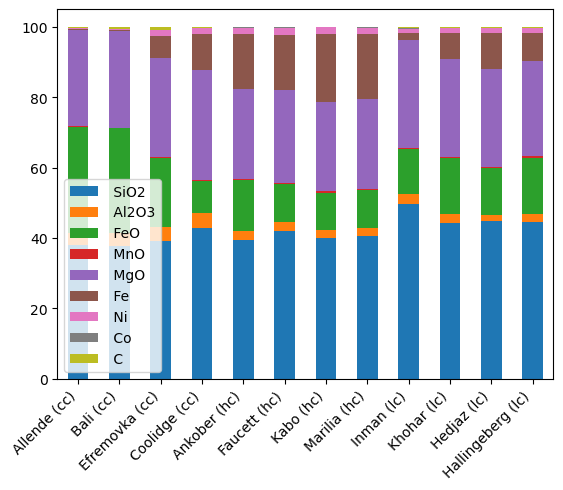

In [25]:
#apply coda closure
data.iloc[:,1:] = data.iloc[:,1:].coda.closure(100)

# Plot
ax = data.plot.bar(stacked=True)

# Set x-axis tick labels
ax.set_xticks(range(len(data.iloc[:,0])))
ax.set_xticklabels(data.iloc[:,0], rotation=45, ha='right')  # Rotate if needed
plt.savefig('../handin/figures/stacked_bar.png', dpi=300, bbox_inches='tight')
plt.show()



we see that there is an obvious difference in the compositions of the meteorise fromt the 12 different origins
How obivius the cc/hc/ic groups overall effect on the compositions is not obious from this plot